In [1]:
import functools
import os
import pprint

In [2]:
import coord
import fitsio
import galsim
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree


In [3]:
import lib

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc9/texlive/2024/bin/x86_64-linux"

In [5]:
# for shear_step, catalog in lib.const.IMSIM_CATALOGS.items():
#     # with h5py.File(catalog, mode="r") as hf_imsim:
#     shear_args = lib.util.parse_shear_arguments(shear_step)
#     print(os.path.basename(os.path.dirname(catalog)))
#     pprint.pp(shear_args)
#     print()

In [6]:
query_radius_arcsec = 1

In [7]:
mdet_step = "noshear"

In [8]:
shear_step = lib.const.SHEAR_STEPS[1]
shear_args = lib.util.parse_shear_arguments(shear_step)

print(shear_step)
pprint.pp(shear_args)

g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0
{'g1_slice': -0.02,
 'g2_slice': 0.0,
 'g1_other': 0.0,
 'g2_other': 0.0,
 'zlow': 0.0,
 'zhigh': 6.0}


In [9]:
g1_slice = shear_args["g1_slice"]
g2_slice = shear_args["g2_slice"]

g1_other = shear_args["g1_other"]
g2_other = shear_args["g2_other"]

zlow = shear_args["zlow"]
zhigh = shear_args["zhigh"]

In [10]:
_catalog = lib.const.IMSIM_CATALOGS[shear_step]
print(_catalog)
hf_imsim = h5py.File(_catalog, mode="r")

/global/cfs/cdirs/des/y6-image-sims/fiducial/g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0/metadetect_cutsv6_all.h5


In [11]:
tilenames = np.unique(hf_imsim["mdet"]["noshear"]["tilename"][:].astype(str))

In [12]:
# tilename = tilenames[0]
tilename = 'DES0402-6039'
print(tilename)

DES0402-6039


In [13]:
wcs = lib.util.load_wcs(tilename)

In [14]:
in_tile = hf_imsim["mdet"][mdet_step]["tilename"][:] == str.encode(tilename)

catalog_indices = np.indices(
    in_tile.shape,
).ravel()

In [15]:
truth_table = fitsio.FITS(lib.const.TRUTH_CATALOGS[tilename])[1]

In [16]:
observed_table = {
    key: hf_imsim["mdet"][mdet_step][key][in_tile]
    for key in [
        "ra", "dec",
        "pgauss_band_flux_g", "pgauss_band_flux_err_g",
        "pgauss_band_flux_r", "pgauss_band_flux_err_r",
        "pgauss_band_flux_i", "pgauss_band_flux_err_i",
        "pgauss_band_flux_z", "pgauss_band_flux_err_z",
    ]
}

In [17]:
shear_slice = galsim.Shear(g1=g1_slice, g2=g2_slice)
shear_other = galsim.Shear(g1=g1_other, g2=g2_other)

In [18]:
# https://github.com/des-science/montara/blob/main/montara/coadd_mixed_scene.py#L76-L94
# https://github.com/des-science/montara/blob/main/montara/z_slice_shear.py#L5-L25

sheared_radec = []
for i in range(truth_table.get_nrows()):
    ra = truth_table["ra_sim"][i]
    dec = truth_table["dec_sim"][i]
    redshift = truth_table["photoz"][i]

    if (redshift > zlow) & (redshift <= zhigh):
        _shear = shear_slice
    else:
        _shear = shear_other

    world_pos = coord.CelestialCoord(ra=ra * coord.degrees, dec=dec * coord.degrees)
    u, v = wcs.center.project(world_pos, projection="gnomonic")
    pos = galsim.PositionD(u.rad, v.rad)

    sheared_pos = pos.shear(_shear)
    u2 = sheared_pos.x * coord.radians
    v2 = sheared_pos.y * coord.radians
    sheared_world_pos = wcs.center.deproject(u2, v2, projection="gnomonic")

    sheared_ra = sheared_world_pos.ra.deg
    sheared_dec = sheared_world_pos.dec.deg

    sheared_radec.append((sheared_ra, sheared_dec))

truth_points = np.deg2rad(np.array(sheared_radec))

In [19]:
_truth_points = np.deg2rad(
    np.array([
        truth_table["ra_sim"][:],
        truth_table["dec_sim"][:],
    ]).T
)

In [20]:
observed_points = np.deg2rad(
    np.array([
        observed_table["ra"],
        observed_table["dec"],
    ]).T
)

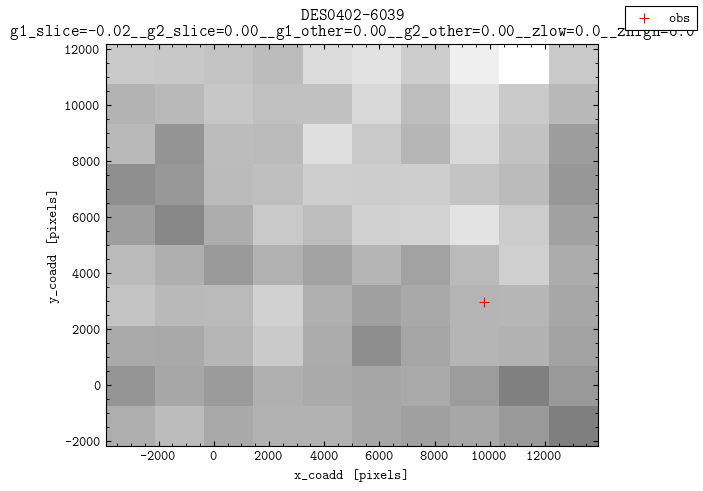

In [21]:
# _size = 500
# xmin = 250
# xmax = xmin + _size
# ymin = 250
# ymax = ymin + _size


true_x, true_y = wcs.toImage(
    truth_points[:, 0],
    truth_points[:, 1],
    units=galsim.radians,
)


obs_x, obs_y = wcs.toImage(
    observed_points[:, 0],
    observed_points[:, 1],
    units=galsim.radians,
)

fig, axs = plt.subplots(1, 1, constrained_layout=True)

axs.hist2d(
    true_x,
    true_y,
    alpha=0.5,
    # s=48,
    # c="b",
    # marker="x",
    # label="truth",
)

axs.scatter(
    obs_x,
    obs_y,
    s=48,
    c="r",
    marker="+",
    label="obs",
)


# axs.set_xlim(xmin, xmax)
# axs.set_ylim(ymin, ymax)

axs.set_xlabel("x_coadd [pixels]")
axs.set_ylabel("y_coadd [pixels]")
axs.set_title(f"{tilename}\n{shear_step}")

fig.legend(loc="outside right upper")

plt.show()

In [22]:
bt = BallTree(
    truth_points,
    metric="haversine",
)

In [38]:
query_radius = np.deg2rad(query_radius_arcsec / 60 / 60)

indices = bt.query_radius(
    observed_points,
    r=query_radius,
)

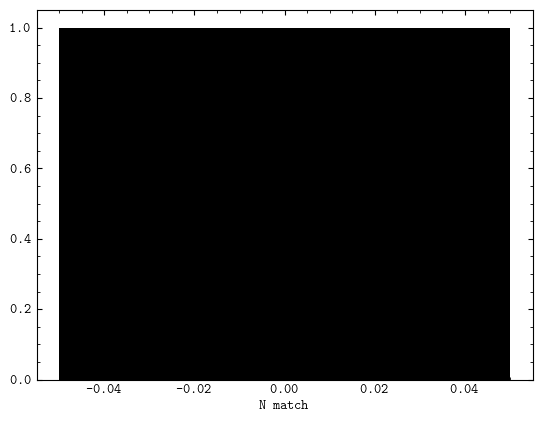

In [40]:
h = np.bincount(list(map(len, indices)))
x = range(len(h))

plt.bar(
    x, h,
    width=0.1,
    fc="k",
)
plt.xlabel("N match")
plt.show()

In [115]:
_min_chi2_indices = np.array([
    np.argsort(
        np.sum(
            [
                np.square(
                    np.divide(
                        np.subtract(
                            observed_table[f"pgauss_band_flux_{band}"][_i],
                            truth_table[f"flux_{band}"][indices[_i]]
                        ),
                        observed_table[f"pgauss_band_flux_err_{band}"][_i]
                    )
                )
                for band in lib.const.BANDS
            ],
            axis=0
        )
    )[0] if len(indices[_i]) > 0 else 0
    for _i in range(len(observed_points))
])

_observed_matched_indices = np.array([
    i
    for (i, _i) in enumerate(indices) if len(_i) > 0
])
_truth_matched_indices = np.array([
    _i[_ii]
    for (_i, _ii) in zip(indices, _min_chi2_indices) if len(_i) > 0
])

# _observed_matched_filter = np.isin(
#     np.arange(len(indices)),
#     _observed_matched_indices,
# )

# _truth_matched_filter = np.isin(
#     np.arange(len(indices)),
#     _truth_matched_indices,
# )

# assert np.unique(_observed_matched_indices, return_counts=True)[1].max() <= 1
# assert len(_truth_matched_indices) == len(_observed_matched_indices)

observed_indices = catalog_indices[in_tile]
observed_matched_indices = catalog_indices[in_tile][_observed_matched_indices]
truth_matched = truth_table[_truth_matched_indices]
# observed_matched_indices = catalog_indices[in_tile][_observed_matched_filter]
# truth_matched = truth_table[_truth_matched_filter]

n_unmatched = len(
    np.setdiff1d(
        observed_indices,
        observed_matched_indices,
    )
)

# return observed_matched_indices, truth_matched


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
_truth_unmatched_indices = np.setdiff1d(
    np.indices((len(truth_points),)).ravel(),
    _truth_matched_indices,
    assume_unique=True
)

_observed_unmatched_indices = np.setdiff1d(
    np.indices((len(observed_points),)).ravel(),
    _observed_matched_indices,
    assume_unique=True
)

In [ ]:
_size = 500
xmin = 250
xmax = xmin + _size
ymin = 250
ymax = ymin + _size


all_true_x, all_true_y = wcs.toImage(
    truth_points[_truth_unmatched_indices, 0],
    truth_points[_truth_unmatched_indices, 1],
    units=galsim.radians,
)
all_true_sel = (
    (all_true_x >= xmin)
    & (all_true_x < xmax)
    & (all_true_y >= ymin)
    & (all_true_y < ymax)
)


all_obs_x, all_obs_y = wcs.toImage(
    observed_points[_observed_unmatched_indices, 0],
    observed_points[_observed_unmatched_indices, 1],
    units=galsim.radians,
)
all_obs_sel = (
    (all_obs_x >= xmin)
    & (all_obs_x < xmax)
    & (all_obs_y >= ymin)
    & (all_obs_y < ymax)
)


true_x, true_y = wcs.toImage(
    truth_points[_truth_matched_indices, 0],
    truth_points[_truth_matched_indices, 1],
    units=galsim.radians,
)
true_sel = (
    (true_x >= xmin)
    & (true_x < xmax)
    & (true_y >= ymin)
    & (true_y < ymax)
)


obs_x, obs_y = wcs.toImage(
    observed_points[_observed_matched_indices, 0],
    observed_points[_observed_matched_indices, 1],
    units=galsim.radians,
)
obs_sel = (
    (obs_x >= xmin)
    & (obs_x < xmax)
    & (obs_y >= ymin)
    & (obs_y < ymax)
)

fig, axs = plt.subplots(1, 1, constrained_layout=True)

axs.scatter(
    all_true_x[all_true_sel],
    all_true_y[all_true_sel],
    s=48,
    ec="b",
    fc="none",
    marker="o",
    label="truth [no match]",
)

axs.scatter(
    true_x[true_sel],
    true_y[true_sel],
    s=48,
    c="b",
    marker="x",
    label="truth [match]",
)

axs.scatter(
    all_obs_x[all_obs_sel],
    all_obs_y[all_obs_sel],
    s=48,
    ec="r",
    fc="none",
    marker="o",
    label="obs [no match]",
)

axs.scatter(
    obs_x[obs_sel],
    obs_y[obs_sel],
    s=48,
    c="r",
    marker="+",
    label="obs [match]",
)


axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

axs.set_xlabel("x_coadd [pixels]")
axs.set_ylabel("y_coadd [pixels]")
axs.set_title(f"{tilename} / r\n{shear_step}")

fig.legend(loc="outside right upper")

plt.show()